# データの読み込み

In [1]:
#tensorboardの拡張機能読み込み
%load_ext tensorboard

In [2]:
#warningはpythonの標準ライブラリ．
#FutureWarnigが邪魔なので非表示にする．動作に支障が無ければ問題ない．また最適化によって解が収束しないときに出るConvergenceWarningも邪魔なので非表示にする．
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=(FutureWarning, ConvergenceWarning))#対象のwarningsクラスはタプルで渡す必要があるらしい

In [3]:
import pprint
import sys
sys.path.append("/mnt/MachineLearning")
pprint.pprint(sys.path)

['/mnt/MachineLearning/MLTrial',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/mnt/MachineLearning']


In [4]:
#各種モジュールのimport
%matplotlib inline
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import statistics

from modules import show_mod
from modules.log_controler import ControlLog

from tqdm.notebook import tqdm

from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras import optimizers
from keras.layers import BatchNormalization
from keras.layers import ReLU, LeakyReLU, PReLU
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, TensorBoard

import optuna

In [7]:
#読み込むデータのパスの設定
current_dir_path = os.getcwd()
data_path = "/mnt/MachineLearning/data"
input_list = glob.glob(data_path+"/*"+"/inputdata.csv")
output_list = glob.glob(data_path+"/CountResults"+"/sitting"+"/count_from2sec_patientAverage.csv")
num_input = len(input_list)
print("data path:", data_path)

data path: /mnt/MachineLearning/data


In [8]:
#input(空調条件等)の読み込み
df_input = None

for input_fname in input_list:
    df_read = pd.read_csv(input_fname, index_col="case_name")
    if df_input is None:
        df_input = df_read
    else:
        df_input = df_input.append(df_read)

df_input

,aircon,ventilation,exhaust,1_x,1_y,1_z,1_angle,2_x,2_y,2_z,2_angle,3_x,3_y,3_z,3_angle,4_x,4_y,4_z,4_angle,5_x,5_y,5_z,5_angle,office_size_x,office_size_y,aircon_position_x,aircon_position_y
case_name,,,,,,,,,,,,,,,,,,,,,,,,,,,
office22_360_164_bout,360,164,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,4.25,3.25
office22_660_246_aout,660,246,a,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,4.25,3.25
office22_660_82_bout,660,82,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,4.25,3.25
office22_660_82_aout,660,82,a,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,4.25,3.25
office22_660_164_bout,660,164,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,4.25,3.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office6_960_82_bout,960,82,b,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,4.734,3.710,1.255,180.0,2.984,2.260,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5,NaN,NaN
office6_660_0,660,0,off,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,4.734,3.710,1.255,180.0,2.984,2.260,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5,NaN,NaN
office6_360_246_aout,360,246,a,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,4.734,3.710,1.255,180.0,2.984,2.260,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5,NaN,NaN


In [9]:
#入力データの選択(オフィスサイズとエアコン位置が被っていると思うので削除)
delete_cols = ["aircon_position_x", "aircon_position_y"]
df_input.drop(df_input[delete_cols], axis=1, inplace=True)
df_input

,aircon,ventilation,exhaust,1_x,1_y,1_z,1_angle,2_x,2_y,2_z,2_angle,3_x,3_y,3_z,3_angle,4_x,4_y,4_z,4_angle,5_x,5_y,5_z,5_angle,office_size_x,office_size_y
case_name,,,,,,,,,,,,,,,,,,,,,,,,,
office22_360_164_bout,360,164,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5
office22_660_246_aout,660,246,a,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5
office22_660_82_bout,660,82,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5
office22_660_82_aout,660,82,a,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5
office22_660_164_bout,660,164,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office6_960_82_bout,960,82,b,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,4.734,3.710,1.255,180.0,2.984,2.260,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5
office6_660_0,660,0,off,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,4.734,3.710,1.255,180.0,2.984,2.260,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5
office6_360_246_aout,360,246,a,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,4.734,3.710,1.255,180.0,2.984,2.260,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5


In [10]:
#排気口位置a,b,offをダミー変数化
df_input = pd.get_dummies(df_input, columns=['exhaust'])
df_input

,aircon,ventilation,1_x,1_y,1_z,1_angle,2_x,2_y,2_z,2_angle,3_x,3_y,3_z,3_angle,4_x,4_y,4_z,4_angle,5_x,5_y,5_z,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off
case_name,,,,,,,,,,,,,,,,,,,,,,,,,,,
office22_360_164_bout,360,164,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,0,1,0
office22_660_246_aout,660,246,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,1,0,0
office22_660_82_bout,660,82,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,0,1,0
office22_660_82_aout,660,82,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,1,0,0
office22_660_164_bout,660,164,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office6_960_82_bout,960,82,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,4.734,3.710,1.255,180.0,2.984,2.260,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5,0,1,0
office6_660_0,660,0,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,4.734,3.710,1.255,180.0,2.984,2.260,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5,0,0,1
office6_360_246_aout,360,246,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,4.734,3.710,1.255,180.0,2.984,2.260,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5,1,0,0


In [46]:
df_output = pd.read_csv(output_list[0], index_col="casename")
df_output

,num_drop,volume[ml],RoI
casename,,,
office2_0_0,6739.4,0.000067,204.224242
office2_0_164_aout,7865.4,0.000063,238.345455
office2_0_164_bout,6049.8,0.000062,183.327273
office2_0_246_aout,7934.4,0.000050,240.436364
office2_0_246_bout,7662.0,0.000082,232.181818
...,...,...,...
office3_960_164_bout,5117.4,0.000075,155.072727
office3_960_246_aout,4428.0,0.000073,134.181818
office3_960_246_bout,3890.0,0.000066,117.878788


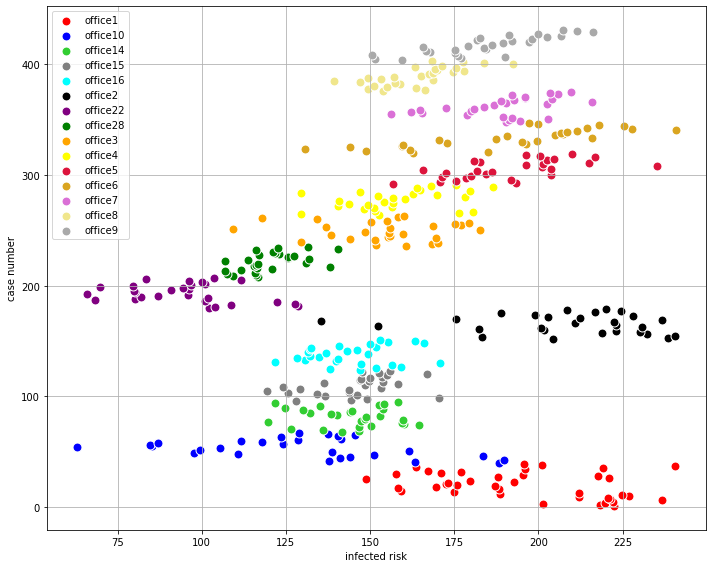

In [12]:
#df_outputの値の幅を見てみる
#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = df_output.index.str.extract("(office+[0-9]{1,2})").to_numpy()

plt.figure(figsize=[10, 8])

#カラーマップ等の準備
markers = ("s", "x", "o", "^", "v", "<", ">", "1", "2", "3", "4", "8")
colors = ("red", "blue", "limegreen", "gray", "cyan", "black", "purple", "green",
          "orange", "yellow", "crimson", "goldenrod", "orchid", "khaki", "darkgray")
start_index = 0

for idx, target_office_name in enumerate(np.unique(office_list)):
    target_office_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == target_office_name)]
    plt.scatter(df_output.iloc[target_office_index ,2], range(1+start_index, len(target_office_index)+1+start_index), 
                s=80, c=colors[idx], marker=markers[2], edgecolor="white", label=target_office_name)
    start_index += len(target_office_index)
    

plt.ylabel("case number")
plt.xlabel("infected risk")
plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

In [47]:
#今回は分類問題なので，感染リスクの値をラベリングして離散化する
RoI_max = df_output.max(axis=0)["RoI"]
RoI_min = df_output.min(axis=0)["RoI"]

#分類のラベルの数を指定
classification_level = 5

level_defference = (RoI_max - RoI_min) / 5

threshold = []#ラベルをつけるための領域を分ける閾値
for i in range(classification_level+1):
    if i == 0:
        threshold.append(RoI_min)
    elif i == classification_level:
        threshold.append(RoI_max)
    else:
        threshold.append(threshold[i-1] + level_defference)

label = []
#感染リスクの行列を参照するためのループ
for RoI in df_output["RoI"]:
    
    #どの領域に入っているかを探るループ
    for i in range(classification_level):
        #カウント漏れや二重カウントを防ぐため，大小比較を調整
        if i == max(range(classification_level)):
            if RoI >= threshold[max(range(classification_level))]:
                label.append(i)
        else:
            if RoI >= threshold[i] and RoI < threshold[i + 1]:
                label.append(i)
                
#データフレーム化
df_label = pd.DataFrame(label, index=df_output.index, columns=["RoI_level"])
#結合
df_output_add = pd.merge(df_output, df_label, left_index=True, right_index=True)
print(f"num null in df:{df_output_add.isnull().values.sum()}")#結合が上手く行っていないかどうか確認
df_output_add

num null in df:0


,num_drop,volume[ml],RoI,RoI_level
casename,,,,
office2_0_0,6739.4,0.000067,204.224242,3
office2_0_164_aout,7865.4,0.000063,238.345455,4
office2_0_164_bout,6049.8,0.000062,183.327273,3
office2_0_246_aout,7934.4,0.000050,240.436364,4
office2_0_246_bout,7662.0,0.000082,232.181818,4
...,...,...,...,...
office3_960_164_bout,5117.4,0.000075,155.072727,2
office3_960_246_aout,4428.0,0.000073,134.181818,2
office3_960_246_bout,3890.0,0.000066,117.878788,1


メモ:\
ラベルを色分けに使って，様々な軸でプロットしたら何かわかりそうな気もする